# Processa os arquivos

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import gsw

# Obtém o diretório atual onde está o notebook
pasta_atual = os.path.dirname(os.path.abspath('__file__'))

# Define o caminho para a pasta onde estão os arquivos
pasta_dados = os.path.join(pasta_atual, 'Dados_SSP_e_Hist')

# Usa a biblioteca glob para obter todos os arquivos NetCDF na pasta
arquivos = glob.glob(os.path.join(pasta_dados, '*.nc'))

# Filtra os arquivos para incluir apenas aqueles com "historical" no nome
arquivos_hist = [arquivo for arquivo in arquivos if "historical" in arquivo]

# Escolhe as latitudes desejadas
latitudes = [-40, -30, -20, -10, -5]

def sal_min(ds):
    idxmin_lev = ds['sa'].argmin(dim='lev')
    sa_min = ds['sa'].min(dim='lev')
    thetao_at_sa_min = ds['thetao'].isel(lev=idxmin_lev)
    lev_at_sa_min = ds['lev'].isel(lev=idxmin_lev)
    sigma0 = gsw.sigma0(sa_min, thetao_at_sa_min)
    return sa_min, thetao_at_sa_min, lev_at_sa_min, sigma0

def encontrar_arquivo_ssp(arquivo_hist, cenario):
    partes = os.path.splitext(os.path.basename(arquivo_hist))[0].split('.')
    modelo_nome1 = partes[1]
    modelo_nome2 = partes[2]
    experimento = partes[3]

    # Construir o caminho do arquivo SSP correspondente
    arquivo_ssp = os.path.join(pasta_dados, f'ScenarioMIP.{modelo_nome1}.{modelo_nome2}.{cenario}.Omon.gn.nc')

    return arquivo_ssp

def processar_modelo(arquivo_hist, arquivo_ssp, latitudes, cenario):
    modelo = os.path.splitext(os.path.basename(arquivo_hist))[0].split('.')[2]

    resultados = []

    for lat in latitudes:
        ds_hist = xr.open_dataset(arquivo_hist)
        ds_ssp = xr.open_dataset(arquivo_ssp)

        levels = np.arange(100, 1500, 1)
        ds_hist = ds_hist.interp(lev=levels, method="linear")
        ds_ssp = ds_ssp.interp(lev=levels, method="linear")

        sa_hist, t_hist, lev_hist, sigma_hist = sal_min(ds_hist.sel(lat=lat, method='nearest'))
        sa_ssp, t_ssp, lev_ssp, sigma_ssp = sal_min(ds_ssp.sel(lat=lat, method='nearest'))

        diff_s = sa_ssp - sa_hist
        diff_t = t_ssp - t_hist
        diff_lev = lev_ssp - lev_hist
        diff_sigma = sigma_ssp - sigma_hist

        resultados.append({
            'Latitude': lat,
            f'Diferença de Salinidade ({cenario})': diff_s.values,
            f'Diferença de Temperatura ({cenario})': diff_t.values,
            f'Profundidade Histórica ({cenario})': lev_hist.values,
            f'Diferença Profundidade ({cenario})': diff_lev.values,
            f'Sigma Histórica ({cenario})': sigma_hist.values,
            f'Diferença Sigma ({cenario})': diff_sigma.values
        })

    # Salvar os resultados em um arquivo CSV
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(f'Diferenças_Cenarios/resultados_{modelo}_{cenario}.csv', index=False)

# Iterar sobre os arquivos históricos
for arquivo_hist in arquivos_hist:
    # Encontrar o arquivo SSP correspondente para ssp585
    arquivo_ssp_585 = encontrar_arquivo_ssp(arquivo_hist, 'ssp585')
    
    # Verificar se o arquivo SSP correspondente existe
    if os.path.exists(arquivo_ssp_585):
        processar_modelo(arquivo_hist, arquivo_ssp_585, latitudes, 'ssp585')
    else:
        print(f"Arquivo SSP correspondente não encontrado para {arquivo_hist} - ssp585")

    # Encontrar o arquivo SSP correspondente para ssp370
    arquivo_ssp_370 = encontrar_arquivo_ssp(arquivo_hist, 'ssp370')

    # Verificar se o arquivo SSP correspondente existe
    if os.path.exists(arquivo_ssp_370):
        processar_modelo(arquivo_hist, arquivo_ssp_370, latitudes, 'ssp370')
    else:
        print(f"Arquivo SSP correspondente não encontrado para {arquivo_hist} - ssp370")


# Realiza as plotagens

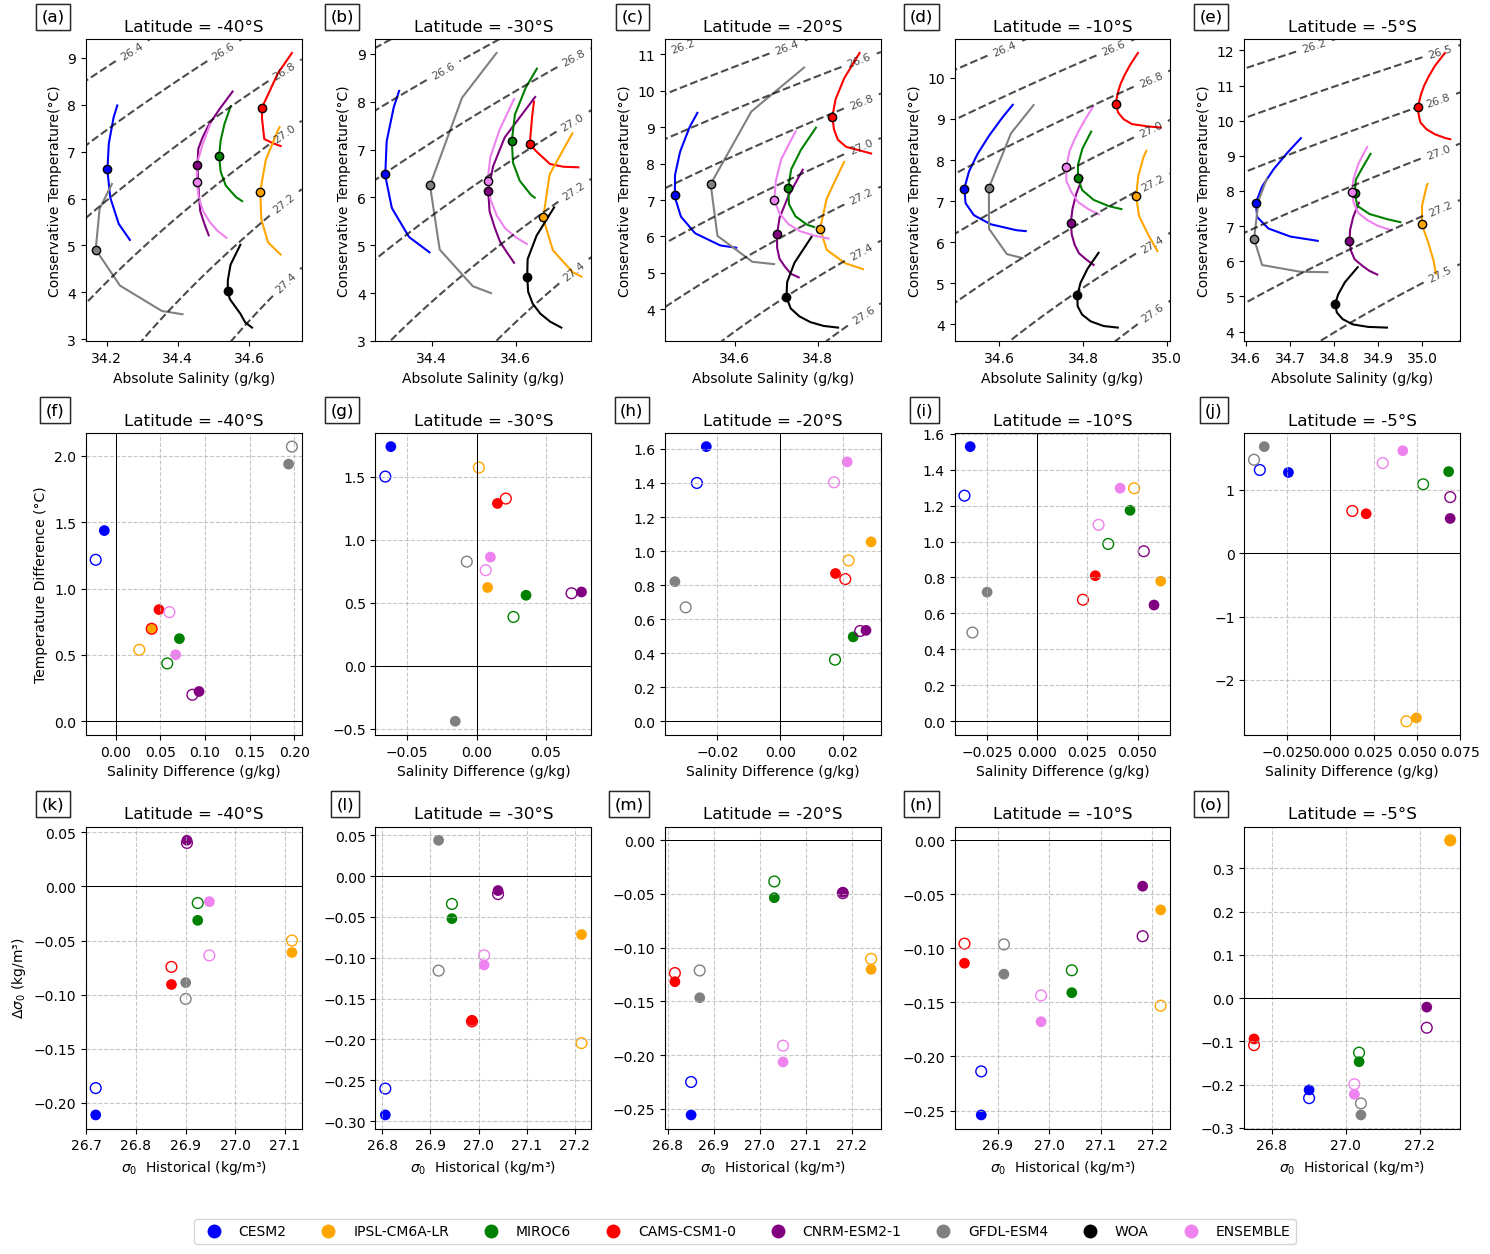

In [3]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import gsw

# Define o tamanho de algumas variáveis
s = 60

# Lista de modelos
modelos = ['CESM2', 'IPSL-CM6A-LR', 'MIROC6', 'CAMS-CSM1-0', 'CNRM-ESM2-1', 'GFDL-ESM4', 'WOA', 'ENSEMBLE']  # Substitua pelos nomes reais dos modelos

# Dicionário para associar cada modelo a uma cor específica
cores_modelos = {
    'CESM2': 'blue',
    'IPSL-CM6A-LR': 'orange',
    'MIROC6': 'green',
    'CAMS-CSM1-0': 'red',
    'CNRM-ESM2-1': 'purple',
    'GFDL-ESM4': 'gray',
    'WOA': 'black',
    'ENSEMBLE' : 'violet'
}

# Dicionário para armazenar os DataFrames de cada modelo
dataframes = {}

# Carregar DataFrames de cada modelo
for modelo in modelos:
    nome_arquivo = f"Diferencas_Historicas/resultados_Diferenças_{modelo}.csv"
    dataframes[modelo] = pd.read_csv(nome_arquivo)

# Lista de latitudes desejadas
latitudes_desejadas = [-40, -30, -20, -10, -5]

# Obtém o diretório atual onde está o notebook
pasta_atual = os.path.dirname(os.path.abspath('__file__'))

# Define o caminho para a pasta onde estão os arquivos
pasta_dados = os.path.join(pasta_atual, 'Dados_SSP_e_Hist')

# Usa a biblioteca glob para obter todos os arquivos NetCDF na pasta
arquivos = glob.glob(os.path.join(pasta_dados, '*.nc'))

# Filtra os arquivos para incluir apenas aqueles com "historical" no nome
arquivos_hist = [arquivo for arquivo in arquivos if "historical" in arquivo]

# Configuração dos subplots
num_linhas = 3
num_colunas = len(latitudes_desejadas)

# Criar subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 12))

# Dicionário para armazenar os dados de cada modelo
dados_modelos = {}

# Plotagem dos diagramas TS (primeira linha)
for j, latitude_desejada in enumerate(latitudes_desejadas):
    ax_ts = axs[0, j]
    
    for arquivo in arquivos_hist:
        ds = xr.open_dataset(arquivo)
        modelo = os.path.splitext(arquivo)[0].split('.')[2]
        levels = np.arange(200, 1500, 5)
        ds = ds.interp(lev=levels, method='linear')
        thetao = ds.sel(lat=latitude_desejada, method="nearest").thetao.values
        sa = ds.sel(lat=latitude_desejada, method="nearest").sa.values
        
        # Encontrar o índice da salinidade mínima
        min_sal_idx = np.argmin(sa)
        
        # Definir os limites de profundidade
        min_depth_idx = max(0, min_sal_idx - 30)
        max_depth_idx = min(len(levels) - 1, min_sal_idx + 50)
        
        # Filtrar os dados para as profundidades desejadas
        thetao_filtered = thetao[min_depth_idx:max_depth_idx]
        sa_filtered = sa[min_depth_idx:max_depth_idx]
        
        ax_ts.plot(sa_filtered, thetao_filtered, color=cores_modelos[modelo])
        
        # Adicionar scatter plot no ponto de mínima salinidade
        ax_ts.scatter(sa[min_sal_idx], thetao[min_sal_idx], color=cores_modelos[modelo], edgecolor='black', zorder=5)

    # Adiciona os dados do WOA
    woa = xr.open_dataset(r"C:\Users\gabri\Documents\Pasta_Atual\Hovmoller_Lon\Tendencias_WOA\woa_mean.nc")
    levels = np.arange(200, 1500, 5)
    woa = woa.interp(depth=levels)
    c_t = woa.sel(lat=latitude_desejada).c_t.values
    s_an = woa.sel(lat=latitude_desejada).s_an.values
    
    # Encontrar o índice da salinidade mínima para WOA
    min_sal_idx_woa = np.argmin(s_an)
    
    # Definir os limites de profundidade para WOA
    min_depth_idx_woa = max(0, min_sal_idx_woa - 30)
    max_depth_idx_woa = min(len(levels) - 1, min_sal_idx_woa + 50)
    
    # Filtrar os dados para as profundidades desejadas para WOA
    c_t_filtered = c_t[min_depth_idx_woa:max_depth_idx_woa]
    s_an_filtered = s_an[min_depth_idx_woa:max_depth_idx_woa]
    
    ax_ts.plot(s_an_filtered, c_t_filtered, color="black")
    ax_ts.scatter(s_an[min_sal_idx_woa], c_t[min_sal_idx_woa], color="black")

# Adicionar linhas de contorno de densidade com base nos limites dos eixos atuais

# Loop através das subplots (no caso específico da primeira linha)
for j, latitude_desejada in enumerate(latitudes_desejadas):
    ax_ts = axs[0, j]
    
    # Ajustar os limites com base no intervalo dos dados sem contornos
    xlim = ax_ts.get_xlim()
    ylim = ax_ts.get_ylim()
    
    # Criar uma malha com base nos limites dos eixos
    sa_grid, ct_grid = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), 
                                   np.linspace(ylim[0], ylim[1], 100))
    sigma0_grid = gsw.sigma0(sa_grid, ct_grid)
    
    # Adicionar contornos
    contornos = ax_ts.contour(sa_grid, ct_grid, sigma0_grid, colors='k', linestyles='dashed', alpha=0.7)
    
    # Adicionar rótulos aos contornos
    ax_ts.clabel(contornos, inline=True, fontsize=8, fmt='%1.1f')

    # Configurar os limites dos eixos
    ax_ts.set_xlim(xlim)
    ax_ts.set_ylim(ylim)

    # Adicionar título e rótulos aos eixos
    ax_ts.set_title(f"Latitude = {latitude_desejada}°S")
    ax_ts.set(xlabel='Absolute Salinity (g/kg)', ylabel='Conservative Temperature(°C)')

# Ajustar layout para evitar sobreposição de rótulos
plt.tight_layout()

#Define o tamanho de algumas variáveis: 
s = 60

# Lista de modelos
modelos = ['CESM2', 'IPSL-CM6A-LR', 'MIROC6', 'CAMS-CSM1-0', 'CNRM-ESM2-1', 'GFDL-ESM4', 'ENSEMBLE']  # Substitua pelos nomes reais dos modelos

# Dicionário para armazenar os DataFrames de cada modelo para ssp585 e ssp370
dataframes_ssp585 = {}
dataframes_ssp370 = {}

# Carregar DataFrames de cada modelo para ssp585 e ssp370
for modelo in modelos:
    nome_arquivo_ssp585 = f"Diferenças_Cenarios/resultados_{modelo}_ssp585.csv"
    nome_arquivo_ssp370 = f"Diferenças_Cenarios/resultados_{modelo}_ssp370.csv"

    dataframes_ssp585[modelo] = pd.read_csv(nome_arquivo_ssp585)
    dataframes_ssp370[modelo] = pd.read_csv(nome_arquivo_ssp370)

# Lista de latitudes desejadas
latitudes_desejadas = [-40, -30, -20, -10, -5]  # Adicione ou remova latitudes conforme necessário

# Definir uma paleta de cores específica para cada modelo
paleta_cores = sns.color_palette("husl", n_colors=len(modelos))

# Adicionar letras acima dos subplots no lado esquerdo
letters = string.ascii_lowercase[:num_linhas * num_colunas]
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.1, f"({letters[i]})", transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7))

# Definir uma paleta de cores específica para cada modelo
paleta_cores = sns.color_palette("husl", n_colors=len(modelos))

# Lista de grandezas para plotagem
grandezas = ['Temperatura e Salinidade', 'Sigma0']

# Loop através de cada latitude para plotar as grandezas
for i, grandeza in enumerate(grandezas):
    for j, latitude_desejada in enumerate(latitudes_desejadas):
        ax = axs[i + 1, j]
        handles_ssp585 = []  # Lista para armazenar handles dos marcadores preenchidos

        for modelo in modelos:
            df_ssp585 = dataframes_ssp585[modelo]
            df_ssp370 = dataframes_ssp370[modelo]

            if grandeza == 'Temperatura e Salinidade':
                # Scatter plot para ssp585 (marcadores preenchidos)
                scatter_ssp585 = ax.scatter(
                    df_ssp585[df_ssp585['Latitude'] == latitude_desejada]['Diferença de Salinidade (ssp585)'],
                    df_ssp585[df_ssp585['Latitude'] == latitude_desejada]['Diferença de Temperatura (ssp585)'],
                    label=f"{modelo} - ssp585", marker='o', facecolors=cores_modelos[modelo], edgecolors='none', s=s)

                # Scatter plot para ssp370 (marcadores apenas com bordas)
                ax.scatter(
                    df_ssp370[df_ssp370['Latitude'] == latitude_desejada]['Diferença de Salinidade (ssp370)'],
                    df_ssp370[df_ssp370['Latitude'] == latitude_desejada]['Diferença de Temperatura (ssp370)'],
                    label=None, marker='o', facecolors='none', edgecolors=cores_modelos[modelo], s=s)

                # Destacar linha 0 nos eixos x e y
                ax.axhline(y=0, color='black', linestyle='-', linewidth=0.7)
                ax.axvline(x=0, color='black', linestyle='-', linewidth=0.7)

                ax.set(xlabel='Salinity Difference (g/kg)')
                if (i, j) == (0, 0):
                    ax.set(ylabel="Temperature Difference (°C)")
                
                # Adicionar grid
                ax.grid(True, linestyle='--', alpha=0.7)
            
            elif grandeza == 'Sigma0':
                # Scatter plot para ssp585 (marcadores preenchidos)
                scatter_ssp585 = ax.scatter(
                    df_ssp585[df_ssp585['Latitude'] == latitude_desejada]['Sigma Histórica (ssp585)'],
                    df_ssp585[df_ssp585['Latitude'] == latitude_desejada]['Diferença Sigma (ssp585)'],
                                        label=f"{modelo} - ssp585", marker='o', facecolors=cores_modelos[modelo], edgecolors='none', s=s)

                # Scatter plot para ssp370 (marcadores apenas com bordas)
                ax.scatter(
                    df_ssp370[df_ssp370['Latitude'] == latitude_desejada]['Sigma Histórica (ssp370)'],
                    df_ssp370[df_ssp370['Latitude'] == latitude_desejada]['Diferença Sigma (ssp370)'],
                    label=None, marker='o', facecolors='none', edgecolors=cores_modelos[modelo], s=s)

                # Destacar linha 0 no eixo y
                ax.axhline(y=0, color='black', linestyle='-', linewidth=0.7)
                
                ax.set(xlabel=r'$\sigma_0$  Historical (kg/m³)') 
                if (i, j) == (1, 0):
                    ax.set(ylabel=r'$\Delta \sigma_0$ (kg/m³)')
               
                # Adicionar grid
                ax.grid(True, linestyle='--', alpha=0.7)
                
            handles_ssp585.append(scatter_ssp585)  # Adicionar handle do ssp585 à lista

        ax.set_title(f"Latitude = {latitude_desejada}°S")

# Ajustar layout para evitar sobreposição de rótulos
plt.tight_layout()

# Adicionar letras acima dos subplots no lado esquerdo
letters = string.ascii_lowercase[:num_linhas * num_colunas]
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.1, f"({letters[i]})", transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7))

# Lista de modelos
modelos = ['CESM2', 'IPSL-CM6A-LR', 'MIROC6', 'CAMS-CSM1-0', 'CNRM-ESM2-1', 'GFDL-ESM4', 'WOA', 'ENSEMBLE']  # Substitua pelos nomes reais dos modelos

# Dicionário para associar cada modelo a uma cor específica
cores_modelos = {
    'CESM2': 'blue',
    'IPSL-CM6A-LR': 'orange',
    'MIROC6': 'green',
    'CAMS-CSM1-0': 'red',
    'CNRM-ESM2-1': 'purple',
    'GFDL-ESM4': 'gray',
    'WOA': 'black',
    'ENSEMBLE' : 'violet'
}

# Adicionar legenda personalizada com a cor e nome do modelo (apenas círculos preenchidos)
handles_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cores_modelos[modelo], markeredgecolor='none', markersize=10, label=f"{modelo}")
                  for modelo in modelos]

# Adicionar a legenda ao plot
fig.legend(handles=handles_legend, loc='lower center', ncol=len(modelos), bbox_to_anchor=(0.5, -0.05), fontsize=10)

plt.savefig("Figura_Evento_e_Artigo.png", bbox_inches='tight', dpi=300)
plt.show()
